<a href="https://colab.research.google.com/github/vvvipindsm/Interview/blob/master/predcition_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install fiftyone
!pip install pandas 
!pip install pmdarima
!pip install seaborn 
!pip install statsmodels 
!pip install yfinance
import statsmodels.api as sm
import yfinance
import pandas as pd
import glob
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
nifty_raw_data = yfinance.download (tickers = "^NSEI ^GSPC", start = "2008-01-08", 
                              end = "2022-06-27", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  2 of 2 completed


In [9]:
df_comp = nifty_raw_data.copy()

df_comp['nifty'] = df_comp['^NSEI'].Close[:]


df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp = df_comp.iloc[1:]
del df_comp['^GSPC']
del df_comp['^NSEI']




df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')
#spa
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100

df_comp['ret_nifty'] = df_comp.nifty.pct_change(1).mul(100)
df_comp['norm_ret_nifty'] = df_comp.ret_nifty.div(df_comp.ret_nifty[1])*100
size = int(len(df_comp)*0.8)
train, valid = df_comp.iloc[:size], df_comp.iloc[size:]


In [7]:
from pmdarima.arima import auto_arima

In [10]:
para_index =1
model = auto_arima(train.ret_nifty[para_index:],exogenous = train[['ret_spx']][para_index:],start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12156.574, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11257.413, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12154.574, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10969.569, Time=0.78 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10745.817, Time=1.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=10639.105, Time=1.35 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=10581.424, Time=1.50 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=15.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=16.00 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=10579.425, Time=2.23 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=10637.106, Time=1.16 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=6.15 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, 

In [11]:
model

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [14]:
df_auto_pred = pd.DataFrame(model.predict(n_periods = len(valid),
                            exogenous = valid[['ret_spx']]),
                            index = valid.index)

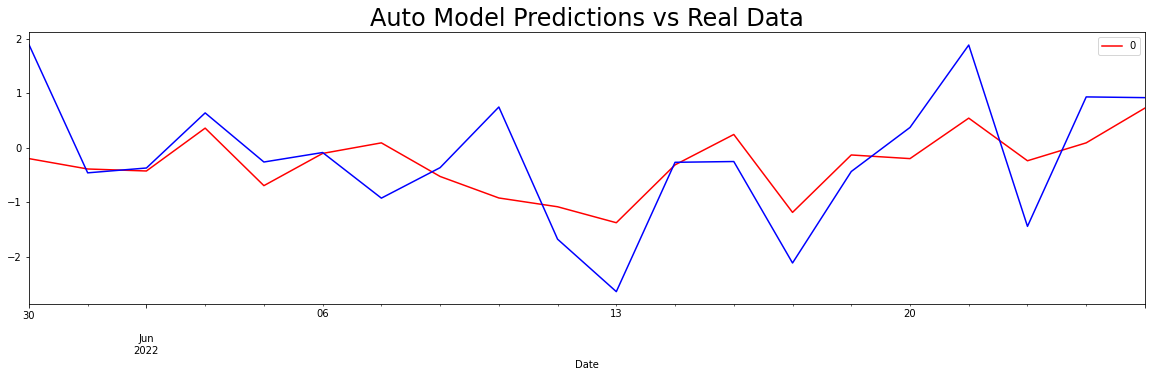

In [25]:
df_auto_pred[-20:].plot(figsize = (20,5), color = "red")
valid.ret_nifty[-20:].plot(color = "blue",label="Test Data")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

In [26]:
new_model = sm.tsa.ARIMA(train.ret_nifty[para_index:],order=(5, 1, 0))
fit = fit_dd = new_model.fit()
prediction = fit.forecast(steps=11)

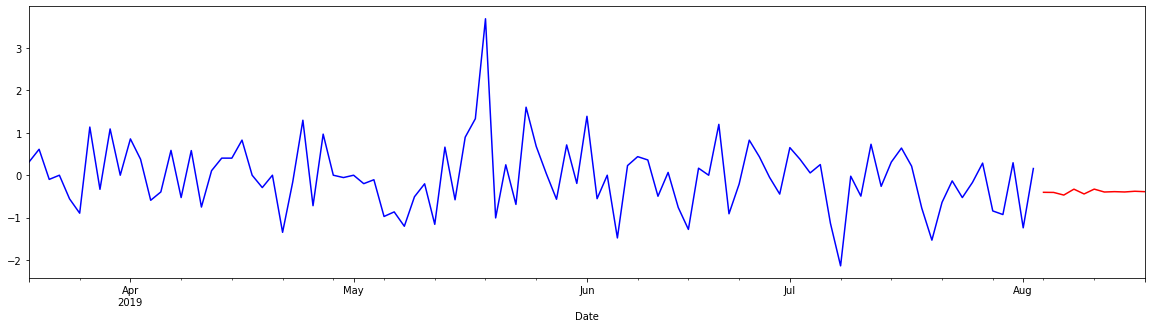

In [35]:
prediction_series = pd.Series(prediction)
# fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(data.Value)
train.ret_nifty[-100:].plot(color = "blue",figsize = (20,5))

prediction_series.plot(color = "red")
plt.show()